In [1]:
get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
pylab.rcParams["figure.figsize"] = (5.0, 4.0)
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.linear_model import LogisticRegression
from matplotlib import pylab
pylab.rcParams["figure.figsize"] = (5.0, 4.0)
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer

# Data Import and Exploration

In [2]:
data1 = pd.read_csv("./il_statewide_2020_04_01.csv")

In [3]:
print("There are",data1.shape[0], 'rows in this complete dataset.')

There are 12748173 rows in this complete dataset.


Due to computer speed concerns, I am using only a subset of the data (100,000 samples as opposed to the 1.2 million in the original CSV file.) The code below works on larger datasets, but takes significant computer resources.

In [4]:
data = data1.sample(n=100000, random_state=42)

In [5]:
print('There are', data.shape[0], 'rows and', data.shape[1], 'columns (variables) in the subsetted dataset used for further analysis.')

There are 100000 rows and 29 columns (variables) in the subsetted dataset used for further analysis.


In [6]:
print('The columns (variables) in this dataset are', data.columns.tolist())

The columns (variables) in this dataset are ['raw_row_number', 'date', 'time', 'location', 'beat', 'subject_age', 'subject_race', 'subject_sex', 'department_id', 'department_name', 'type', 'violation', 'citation_issued', 'warning_issued', 'outcome', 'contraband_found', 'contraband_drugs', 'contraband_weapons', 'search_conducted', 'search_person', 'search_vehicle', 'search_basis', 'reason_for_stop', 'vehicle_make', 'vehicle_year', 'raw_DriverRace', 'raw_ReasonForStop', 'raw_TypeOfMovingViolation', 'raw_ResultOfStop']


In [7]:
data.describe()

,raw_row_number,subject_age,department_id,vehicle_year,raw_DriverRace,raw_ReasonForStop,raw_TypeOfMovingViolation,raw_ResultOfStop
count,1.000000e+05,75.000000,100000.000000,99894.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,6.363389e+06,33.213333,13489.823710,2005.272579,1.798940,1.458280,1.640210,1.756950
std,3.684847e+06,12.682498,350.529826,6.860235,7.815235,0.735082,1.898557,0.795904
min,1.300000e+01,17.000000,10011.000000,1900.000000,1.000000,1.000000,0.000000,1.000000
25%,3.179948e+06,25.000000,13194.000000,2001.000000,1.000000,1.000000,0.000000,1.000000
50%,6.355212e+06,29.000000,13439.000000,2006.000000,1.000000,1.000000,1.000000,2.000000
75%,9.563472e+06,38.000000,13864.000000,2010.000000,2.000000,2.000000,2.000000,2.000000
max,1.274792e+07,78.000000,14150.000000,2018.000000,999.000000,4.000000,6.000000,3.000000


# Data Cleaning and Preprocessing

First, we remove the variables that are not necessary for our analysis.

* <b>raw_row_number:</b> not necessary for our anaylsis, as we are able to use the index values
* <b>type:</b> all values in this table are 'vehicular'
* <b>department_name:</b> department_id (another variable in the data) gives the same information.

In [8]:
data = data.drop(['raw_row_number', 'type', 'department_name'], 1)

Next, we find which variables are missing values.

In [9]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("The dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [10]:
mv = missing_values_table(data)
mv

The dataframe has 26 columns.
There are 15 columns that have missing values.


,Missing Values,% of Total Values
subject_age,99925,99.9
search_basis,98484,98.5
contraband_found,95499,95.5
contraband_drugs,95499,95.5
contraband_weapons,95499,95.5
vehicle_make,2597,2.6
beat,1858,1.9
location,957,1.0
search_vehicle,141,0.1
search_conducted,138,0.1


Then, we remove feature columns that have over 95% missing values.

In [11]:
over95 = list(pd.DataFrame(mv[mv['% of Total Values'] > 95].any(1)).index)
print('Columns missing over 95% of values:',over95)

Columns missing over 95% of values: ['subject_age', 'search_basis', 'contraband_found', 'contraband_drugs', 'contraband_weapons']


In [12]:
data = data.drop(over95, 1)

Remove the rows that do not have outcome, as this is an important target variable. 

In [13]:
data = data[data['outcome'].notna()]

Format the variables according to their type.

In [14]:
data['search_person'] = data['search_person'].astype('bool')
data['search_vehicle'] = data['search_vehicle'].astype('bool')
data['search_person'] = data['search_person'].astype('bool')
data["time"]= pd.to_datetime(data["time"])
data["date"]= pd.to_datetime(data["date"])
data['outcome'] = data['outcome'].astype('str')
data['location'] = data['location'].astype('str')
data['violation'] = data['violation'].astype('str')

In [15]:
len(data.columns)

21

In [16]:
data.dtypes

date                         datetime64[ns]
time                         datetime64[ns]
location                             object
beat                                 object
subject_race                         object
subject_sex                          object
department_id                       float64
violation                            object
citation_issued                        bool
warning_issued                         bool
outcome                              object
search_conducted                     object
search_person                          bool
search_vehicle                         bool
reason_for_stop                      object
vehicle_make                         object
vehicle_year                        float64
raw_DriverRace                        int64
raw_ReasonForStop                     int64
raw_TypeOfMovingViolation             int64
raw_ResultOfStop                      int64
dtype: object

Create dummy variables for race and sex.

In [17]:
data_dummies_race = pd.get_dummies(data['subject_race'])
data = data.join(data_dummies_race)

In [18]:
data_dummies_sex = pd.get_dummies(data['subject_sex'])
data.drop(['subject_sex'],axis=1,inplace=True)
data = data.join(data_dummies_sex)

Use SimpleImputer to impute missing values.

In [19]:
columns = data.columns.tolist()

In [20]:
imputer = SimpleImputer(missing_values = np.nan,
                        strategy ='most_frequent')
imputer = imputer.fit(data)
data = imputer.transform(data)
data = pd.DataFrame(data, columns = columns)

Remove duplicative race column.

In [21]:
data = data.drop('raw_DriverRace', 1)

Format target variables to be 0 and 1 (as opposed to boolean)

In [22]:
data["search_conducted"] = data["search_conducted"].astype(int)
data['citation_issued'] = data['citation_issued'].astype(int)

Check to see if any data errors (as in there is a row with both warning and citation used or neither).

In [23]:
data['citation_issued'].value_counts()

0    53221
1    46779
Name: citation_issued, dtype: int64

In [24]:
data['warning_issued'].value_counts()

True     53221
False    46779
Name: warning_issued, dtype: int64

In [25]:
data['outcome'].value_counts()

warning     53221
citation    46779
Name: outcome, dtype: int64

There is not, so we can remove the duplicative columns and just use the target variable column. We will use the column 'citation', which has 1 for True and 0 for False, as our target outcome variable.

In [26]:
data = data.drop(['warning_issued', 'outcome'], 1)

Remove duplicative column.

Create dummies for violation and reason columns and drop the raw columns.

In [27]:
data_dummies_violation = pd.get_dummies(data['violation'], prefix='violation')
data.drop(['violation'],axis=1,inplace=True)
data = data.join(data_dummies_violation)
data = data.drop('raw_TypeOfMovingViolation', 1)

In [28]:
data_dummies_reason = pd.get_dummies(data['reason_for_stop'], prefix='reason_')
data.drop(['reason_for_stop'],axis=1,inplace=True)
data = data.join(data_dummies_reason)
data = data.drop('raw_ResultOfStop', 1)

Create dummies for date column. Separate times into 8 time-of-day buckets (as was done in the paper I am assessing).

In [29]:
data['time'] = (data['time'].dt.hour % 24 + 3) // 3
data['time'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Late Morning',
                      5: 'Noon',
                      6: 'Late Afternoon',
                      7: 'Evening',
                      8: 'Night'}, inplace=True)

In [30]:
data_dummies_time = pd.get_dummies(data['time'])
data.drop(['time'],axis=1,inplace=True)
data = data.join(data_dummies_time)

Create dummies for whether the location is urban or rural and drop location variable.

This process uses the US Post Office's designation of Zipcodes (zips.csv) and the USDA's designation of rural and urban (denoted as metro and non-metro) (ruralurbancodes2013.xls). 

In [31]:
zipcodes = pd.read_excel('./ruralurbancodes2013.xls')
zipcodes = zipcodes.loc[zipcodes['State'] == 'IL']
zipcodes['rural'] = zipcodes['Description'].str.contains('Nonmetro')
zipcodes = zipcodes[['County_Name', 'rural']]

zips = pd.read_csv('./zips.csv')
zips = zips.loc[zips['state'] == 'IL']

zipcodes = zipcodes.merge(zips, left_on='County_Name', right_on='county')
zipcodes = zipcodes[['rural', 'zip']]

rural = zipcodes.loc[zipcodes['rural']== False]

rural_list = rural['zip'].tolist()
rural_list = list(map(str, rural_list))

data["rural_or_not"] = np.where(data["location"].isin(rural_list), "rural_location", "urban_location")

In [32]:
data_dummies_rural = pd.get_dummies(data['rural_or_not'])
data.drop(['rural_or_not'],axis=1,inplace=True)
data = data.join(data_dummies_rural)
data = data.drop(['location'], 1)

Create season of the year dummies and drop date variable.

In [33]:
data['season'] = (data['date'].dt.month - 1) // 3
data['season'].replace({1: 'Spring',
                      2: 'Summer',
                      3: 'Fall',
                      0: 'Winter'}, inplace=True)

In [34]:
data_dummies_season = pd.get_dummies(data['season'])
data.drop(['season'],axis=1,inplace=True)
data = data.join(data_dummies_season)
data = data.drop('date', 1)

# Overview of Task

<b>"A large-scale analysis of racial disparities in police stops across the United States" (2020)</b> uses data from the Stanford Open Policing Project to assess racial disparities in police interactions with the public. They compiled and analyzed a dataset detailing over 60 million state patrol stops conducted in 20 U.S. states.
https://5harad.com/papers/traffic-stops.pdf

In their analysis, Pierson, et al. has <b>five main conclusions</b>:

1. <b>Among stopped drivers—and after controlling for age, gender, time, and location—
blacks and Hispanics are more likely to be ticketed than white drivers.</b>
2. <b>Among stopped drivers—and after controlling for age, gender, time, and location—
blacks and Hispanics are more likely to be <b>searched</b> than white drivers.</b>
3. Among stopped drivers—and after controlling for age, gender, time, and location—
blacks and Hispanics are more likely to be arrested than white drivers.
4. In the case of search decisions, we explicitly test for discrimination by examining both
the rate at which drivers are searched and the likelihood searches turn up contraband. We find
evidence that the bar for searching black and Hispanic drivers is lower than for searching whites.
5. Finally, we find that legalizing recreational marijuana in Washington and Colorado reduced the
total number of searches and misdemeanors for all race groups, though a race gap still persists.

I seek to recreate their results, focusing specifically on Illinois. Given data constaints, I am unable to test conclusions 3 through 5, as the dataset does not include arrests or contraband information, and the dataset does not cover 2020, which is when Illinois legalized marijuana.

The original authors of the paper used logistic regression. For my analysis of conclusions 1 and 2, I recreate their logistic regression results and compare my logistic regression model to two other classification models: Linear SVC and SGD Classifier.


## Conclusion 1: Black and Hispanic drivers are more likely to be ticketed (given a citation instead of a warning) than white drivers?

In Pierson et al's analysis, they controlled for age, sex, race, location, and date. Their target variable for this conclusion is whether or not the driver was given a citation (as opposed to a warning).

First, I began by looking at the raw data. I plotted the different rates of citation-issued versus not (with higher percentages denoting more likelihood to receive a citation (ticket) as opposed to getting off with a warning) on a factor plot and a bar plot. We can see that, without controlling for any varibales, Black and Hispanic drivers have higher raw percentages of receiving a citation. This matches the findings that Pierson et al detail in the paper.

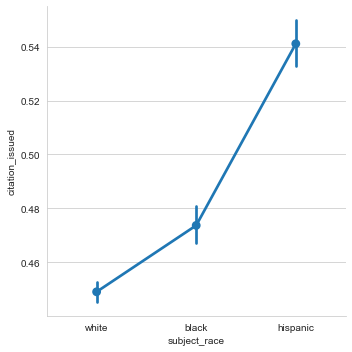

In [35]:
sns.factorplot('subject_race','citation_issued',order=['white', 'black', 'hispanic'],data=data,size=5);

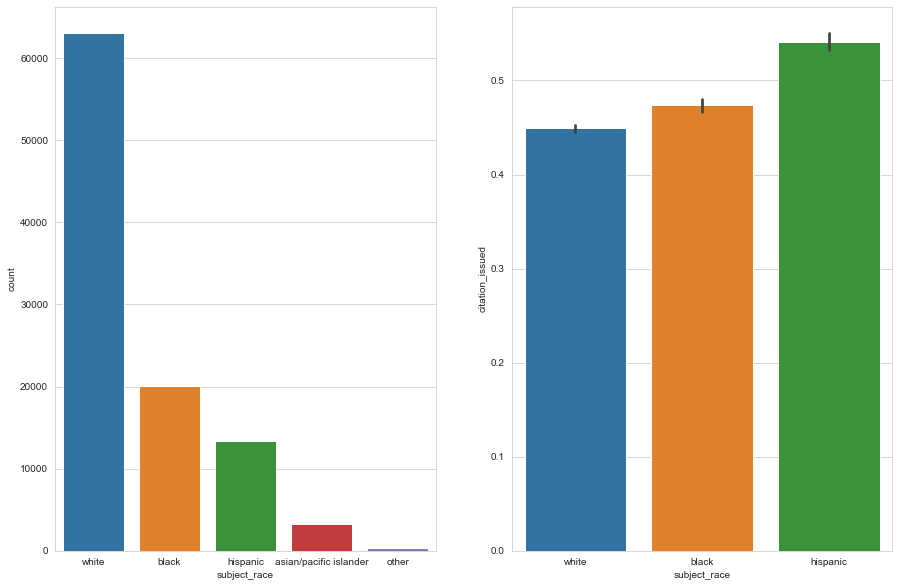

In [36]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,10))

sns.countplot(x='subject_race', data=data, ax=ax1, order=['white','black','hispanic', 'asian/pacific islander', 'other'])
race = data[["subject_race", "citation_issued"]]
sns.barplot(x='subject_race', y='citation_issued', data=race, ax=ax2, order=['white','black','hispanic']);

Next, I begin to run my models to determine feature importance for the classification of citation or no citation. I first list the features that I have available in the dataset. Because I preprocessed the information previously, the data related to this features can be used in my classification model.

In [37]:
features = [
       'search_conducted', 'search_person', 'search_vehicle', 'department_id',
       'vehicle_year', 'raw_ReasonForStop',
       'asian/pacific islander', 'black', 'hispanic',
       'other', 'white', 'female', 'male', 'violation_Equipment', 'violation_Commercial Vehicle','violation_License Plate/Registration',
       'violation_Moving Violation: Follow too close',
       'violation_Moving Violation: Lane Violation',
       'violation_Moving Violation: Other',
       'violation_Moving Violation: Seat Belt',
       'violation_Moving Violation: Speed',
       'violation_Moving Violation: Traffic Sign or Signal', 'Early Morning', 'Evening',
       'Late Afternoon', 'Late Morning', 'Late Night', 'Morning', 'Night',
       'Noon', 'rural_location', 'urban_location', 'Fall', 'Spring', 'Summer',
       'Winter', 'reason__License Plate/Registration']

Next I begin to fit and evaluate my models on my data. The goal of this classification is to see if the the feature variable 'white' (denoting the subject's race) is more negative (or less positive) than the features 'hispanic' and 'black' that denote Hispanic and Black drivers respectively.

<b>Target Variable for Task 1:</b> dummy variable: citation (0 for warning, 1 for citation)

In [38]:
X = np.array(data[features]) 
y = np.array(data['citation_issued'])

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

### Logistic Regression

#### Find Penalty and C-value that maximizes test score.

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [41]:
def compare_penalty_logit(X, y):
    """
    X_data: 2D feature matrix
    y_data: 1D array containing the class labels
    return: 
        a dataframe comparing logistical regression penalty scores
    """
    results = []
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42)
    
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    
    
    for p in (['none','l1', 'l2']):
        effect = {}
        clf = LogisticRegression(penalty=p, solver='saga',
                                 max_iter=1000, random_state=42)
        clf.fit(X_train_std, y_train)
        
        effect['min'] = float("%.3f" % clf.coef_[0].min())
        effect['max'] = float("%.3f" % clf.coef_[0].max())
        effect['mean_abs'] = float("%.3f" % np.abs(clf.coef_[0]).mean())
        effect['n_zero'] = np.sum(clf.coef_[0] == 0)
        effect['test_score'] = float("%.3f" % clf.score(X_test_std, y_test))
        
        results.append(effect)
        
    return pd.DataFrame(results).rename(index={0: 'none', 1:'l1', 
                                                        2: 'l2'})

In [42]:
def compare_c_logit(X_data, y_data, s='saga', p='l2'):
    """
    X_data: 2D feature matrix
    y_data: 1D array containing the class labels
    return: 
        a dataframe comparing logistical regression c scores
    """
    results = []
    
    X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.30, random_state=42)
    
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    
    for c in [0.001, 0.01, 0.1, 1, 10, 100]:
        effect = {}
        clf = LogisticRegression(penalty=p, solver='saga', C = c, max_iter=1000, random_state=42)
        
        clf.fit(X_train_std, y_train)
        
        effect['c'] = c
        effect['min'] = float("%.3f" % clf.coef_[0].min())
        effect['max'] = float("%.3f" % clf.coef_[0].max())
        effect['mean_abs'] = float("%.3f" % np.abs(clf.coef_[0]).mean())
        effect['n_zero'] = np.sum(clf.coef_[0] == 0)
        effect['test_score'] = float("%.3f" % clf.score(X_test_std, y_test))

        results.append(effect)
    
    return pd.DataFrame(results)

In [43]:
compare_penalty_logit(X, y)

,min,max,mean_abs,n_zero,test_score
none,-1.539,0.282,0.217,0,0.616
l1,-0.361,0.288,0.082,5,0.616
l2,-0.695,0.282,0.126,0,0.616


All have the same test score, so select the least-complex model (5 features eliminated in feature selection with L1 penalty).

In [44]:
compare_c_logit(X, y, p='l1', s='saga')

,c,min,max,mean_abs,n_zero,test_score
0,0.001,-0.180,0.201,0.031,20,0.615
1,0.010,-0.195,0.285,0.059,10,0.617
2,0.100,-0.202,0.288,0.063,8,0.616
3,1.000,-0.361,0.288,0.082,5,0.616
4,10.000,-1.379,0.282,0.189,3,0.616
5,100.000,-1.522,0.282,0.214,1,0.616


#### Run model.

In [45]:
def Logit(dataset, target, p, c):
    X = np.array(dataset[features]) 
    y = np.array(dataset[target])
    logreg = LogisticRegression(penalty=p, C=c, tol = 0.1, solver='saga')
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    pipe = make_pipeline(StandardScaler(), logreg)
    pipe.fit(X_train, y_train)

    cv = KFold(n_splits=(10))
    scores = cross_val_score(pipe, X_train, y_train, cv = cv, scoring='f1')
    print("10-fold CV F1 score: {:.3f} +/- {:.3f}".format(np.mean(scores), np.std(scores)))
    
    scores2 = cross_val_score(pipe, X_train, y_train, cv = cv, scoring='roc_auc')
    print("10-fold CV ROC_AUC score: {:.3f} +/- {:.3f}".format(np.mean(scores2), np.std(scores2)))
    
    X_total = np.array(data[features]) 
    y_total = np.array(data[target])
    X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(X_total, y_total, random_state=42)

    y_pred = pipe.predict(X_test_total)
    
    prfs = list(precision_recall_fscore_support(y_test_total, y_pred, average='weighted'))
    perf = ['Logistic Regression', roc_auc_score(y_test_total, y_pred), accuracy_score(y_test_total, y_pred)]
    perf.extend(prfs[:-1])
    
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
    
    coeff_df = pd.DataFrame(features)
    coeff_df.columns = ['Features']
    coeff_df["Coefficient"] = pd.Series(logreg.coef_[0])

    # preview
    coeff_df.sort_values(by='Coefficient', inplace=True)
    
    fig, ax = plt.subplots(figsize=(6,12))
    l = len(features)
    ax.barh(range(l), coeff_df.Coefficient)
    ax.set_xlabel("Feature importance")
    ax.set_ylabel("Feature coefficient")
    ax.set_yticks(range(l))
    y_lb = ax.set_yticklabels(coeff_df.Features)
    
    return coeff_df, tuple(perf), disp
    

10-fold CV F1 score: 0.572 +/- 0.009
10-fold CV ROC_AUC score: 0.666 +/- 0.007


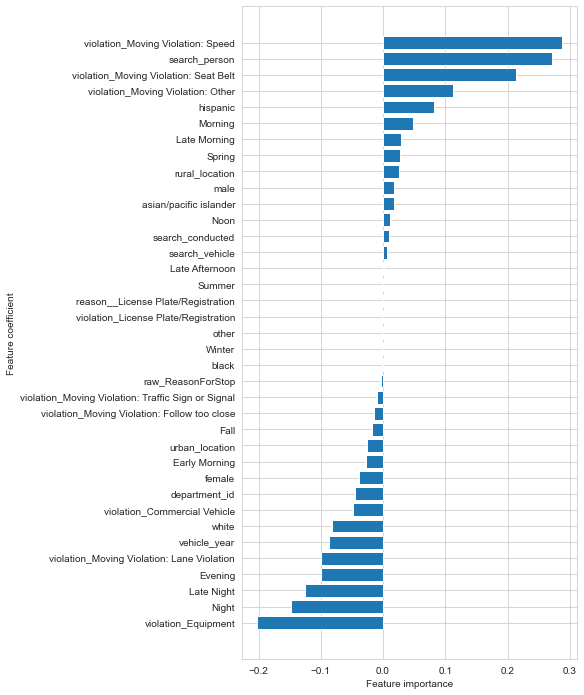

In [46]:
df, logit_perf, logit_disp = Logit(data, 'citation_issued', p='l1', c=0.01)

In [47]:
df

,Features,Coefficient
13,violation_Equipment,-0.201954
28,Night,-0.148252
26,Late Night,-0.124868
23,Evening,-0.099902
17,violation_Moving Violation: Lane Violation,-0.099662
4,vehicle_year,-0.086320
10,white,-0.082560
14,violation_Commercial Vehicle,-0.048306
3,department_id,-0.045239
11,female,-0.038327


#### Findings from Logistic Regression

According to our findings, the 'white' feature is more negative than the 'black' and 'hispanic' features. This supports the findings in the original paper, as more negative means less likely to receive a citation.

### Linear SVC

#### Find Penalty and C-value that maximizes test score.

In [48]:
def compare_penalty_lsvc(X, y):
    """
    X_data: 2D feature matrix
    y_data: 1D array containing the class labels
    return: 
        a dataframe that is shown in the running example below
    """
    ###TODO
    results = []
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42)
    
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    
    
    for p, s, d in zip(['l1', 'l2'],['squared_hinge', 'hinge'], [False, True]):
        effect = {}
        clf = LinearSVC(tol=0.001, penalty=p, dual=d,
                                 random_state=42, loss=s)
        clf.fit(X_train_std, y_train)
        
        effect['min'] = float("%.3f" % clf.coef_[0].min())
        effect['max'] = float("%.3f" % clf.coef_[0].max())
        effect['mean_abs'] = float("%.3f" % np.abs(clf.coef_[0]).mean())
        effect['n_zero'] = np.sum(clf.coef_[0] == 0)
        effect['test_score'] = float("%.3f" % clf.score(X_test_std, y_test))
        
        results.append(effect)
        
    return pd.DataFrame(results).rename(index={0:'l1', 1: 'l2'})

In [49]:
def compare_c_lsvc(X_data, y_data, p='l1', s='squared_hinge', d=False):
    """
    X_data: 2D feature matrix
    y_data: 1D array containing the class labels
    return: 
        a dataframe that is shown in the running example below
    """
    ###TODO
    results = []
    
    X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.30, random_state=42)
    
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    
    for c in [0.001, 0.01, 0.1, 1, 10, 100]:
            effect = {}
            clf = LinearSVC(tol=0.001, penalty=p, dual=d, loss=s,
                                    C = c, random_state=42)

            clf.fit(X_train_std, y_train)

            effect['c'] = c
            effect['min'] = float("%.3f" % clf.coef_[0].min())
            effect['max'] = float("%.3f" % clf.coef_[0].max())
            effect['mean_abs'] = float("%.3f" % np.abs(clf.coef_[0]).mean())
            effect['n_zero'] = np.sum(clf.coef_[0] == 0)
            effect['test_score'] = float("%.3f" % clf.score(X_test_std, y_test))

            results.append(effect)
    
    return pd.DataFrame(results)

In [50]:
compare_penalty_lsvc(X, y)

,min,max,mean_abs,n_zero,test_score
l1,-0.141,0.121,0.033,0,0.617
l2,-0.969,0.445,0.123,0,0.614


In [51]:
compare_c_lsvc(X, y, p='l1',s='squared_hinge', d=False)

,c,min,max,mean_abs,n_zero,test_score
0,0.001,-0.085,0.133,0.025,12,0.617
1,0.010,-0.088,0.138,0.029,8,0.617
2,0.100,-0.127,0.120,0.031,3,0.617
3,1.000,-0.141,0.121,0.033,0,0.617
4,10.000,-0.141,0.121,0.034,0,0.617
5,100.000,-0.141,0.121,0.034,0,0.617


#### Run Model.

In [52]:
def lSVC(dataset, target, p, c, s, d):
    X = np.array(dataset[features]) 
    y = np.array(dataset[target])
    clf = LinearSVC(random_state=0, tol=1e-5, penalty=p, loss=s, dual=d, C=c)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    pipe = make_pipeline(StandardScaler(), clf)
    pipe.fit(X_train, y_train)

    cv = KFold(n_splits=(10))
    scores = cross_val_score(pipe, X_train, y_train, cv = cv, scoring='f1')
    print("10-fold CV F1 score: {:.3f} +/- {:.3f}".format(np.mean(scores), np.std(scores)))
    
    scores2 = cross_val_score(pipe, X_train, y_train, cv = cv, scoring='roc_auc')
    print("10-fold CV ROC_AUC score: {:.3f} +/- {:.3f}".format(np.mean(scores2), np.std(scores2)))
    
    X_total = np.array(data[features]) 
    y_total = np.array(data[target])
    X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(X_total, y_total, random_state=42)
    
    y_pred = pipe.predict(X_test_total)
    
    prfs = list(precision_recall_fscore_support(y_test_total, y_pred, average='weighted'))
    perf = ['LinearSVC', roc_auc_score(y_test_total, y_pred), accuracy_score(y_test_total, y_pred)]
    perf.extend(prfs[:-1])
    
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    
    coeff_df = pd.DataFrame(features)
    coeff_df.columns = ['Features']
    coeff_df["Coefficient"] = pd.Series(clf.coef_[0])

    # preview
    coeff_df.sort_values(by='Coefficient', inplace=True)
    
    fig, ax = plt.subplots(figsize=(6,12))
    l = len(features)
    ax.barh(range(l), coeff_df.Coefficient)
    ax.set_xlabel("Feature importance")
    ax.set_ylabel("Feature coefficient")
    ax.set_yticks(range(l))
    y_lb = ax.set_yticklabels(coeff_df.Features)
    
    return coeff_df, tuple(perf), disp

10-fold CV F1 score: 0.573 +/- 0.009
10-fold CV ROC_AUC score: 0.667 +/- 0.007


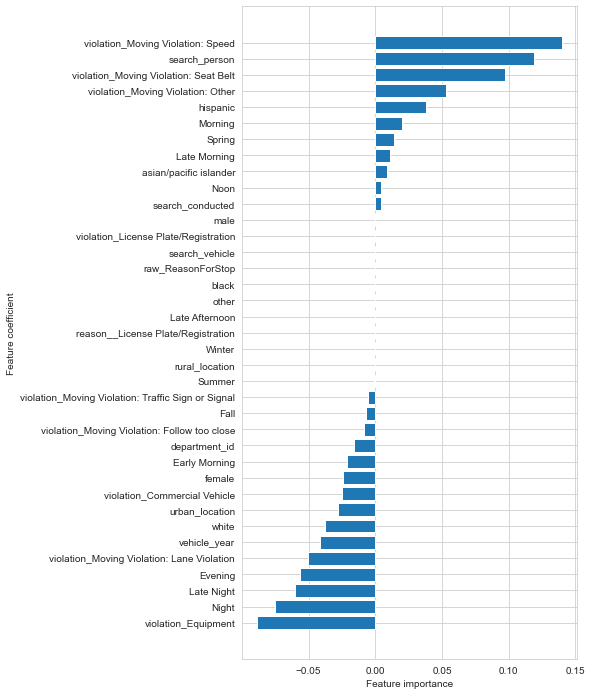

In [53]:
df, lsvc_perf, lsvc_disp = lSVC(data, 'citation_issued', p='l1', c= .01, s='squared_hinge', d=False)

In [54]:
df

,Features,Coefficient
13,violation_Equipment,-0.088364
28,Night,-0.075507
26,Late Night,-0.060128
23,Evening,-0.056470
17,violation_Moving Violation: Lane Violation,-0.050551
4,vehicle_year,-0.041633
10,white,-0.037635
31,urban_location,-0.028255
14,violation_Commercial Vehicle,-0.025338
11,female,-0.024077


#### Findings from Linear SVC Model

Like with the Linear Regression model, the 'white' feature is more negative than the 'black' and 'hispanic' features. This also supports the findings in the original paper.

## SGDClassifier

### Find Penalty that maximizes test score.

In [55]:
def compare_penalty_sgdc(X, y):
    """
    X_data: 2D feature matrix
    y_data: 1D array containing the class labels
    return: 
        a dataframe that is shown in the running example below
    """
    ###TODO
    results = []
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42)
    
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    
    
    for p in (['l1', 'l2']):
        effect = {}
        clf = SGDClassifier(max_iter=1000, tol=1e-3, penalty=p)
        clf.fit(X_train_std, y_train)
        
        effect['min'] = float("%.3f" % clf.coef_[0].min())
        effect['max'] = float("%.3f" % clf.coef_[0].max())
        effect['mean_abs'] = float("%.3f" % np.abs(clf.coef_[0]).mean())
        effect['n_zero'] = np.sum(clf.coef_[0] == 0)
        effect['test_score'] = float("%.3f" % clf.score(X_test_std, y_test))
        
        results.append(effect)
        
    return pd.DataFrame(results).rename(index={0:'l1', 1: 'l2'})

In [56]:
compare_penalty_sgdc(X, y)

,min,max,mean_abs,n_zero,test_score
l1,-0.066,0.844,0.055,24,0.617
l2,-0.326,0.514,0.092,0,0.611


### Run Model.

In [57]:
def SGDC(dataset, target, p):
    X = np.array(dataset[features]) 
    y = np.array(dataset[target])

    clf = SGDClassifier(max_iter=1000, tol=1e-3, penalty=p)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    pipe = make_pipeline(StandardScaler(), clf)
    pipe.fit(X_train, y_train)

    cv = KFold(n_splits=(10))
    scores = cross_val_score(pipe, X_train, y_train, cv = cv, scoring='f1')
    print("10-fold CV F1 score: {:.3f} +/- {:.3f}".format(np.mean(scores), np.std(scores)))
    
    scores2 = cross_val_score(pipe, X_train, y_train, cv = cv, scoring='roc_auc')
    print("10-fold CV ROC_AUC score: {:.3f} +/- {:.3f}".format(np.mean(scores2), np.std(scores2)))
    
    X_total = np.array(data[features]) 
    y_total = np.array(data[target])
    X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(X_total, y_total, random_state=42)
    
    y_pred = pipe.predict(X_test_total)
    
    prfs = list(precision_recall_fscore_support(y_test_total, y_pred, average='weighted'))
    perf = ['SGD Classifier', roc_auc_score(y_test_total, y_pred), accuracy_score(y_test_total, y_pred)]
    perf.extend(prfs[:-1])
    
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    
    coeff_df = pd.DataFrame(features)
    coeff_df.columns = ['Features']
    coeff_df["Coefficient"] = pd.Series(clf.coef_[0])

    # preview
    coeff_df.sort_values(by='Coefficient', inplace=True)
    
    fig, ax = plt.subplots(figsize=(6,12))
    l = len(features)
    ax.barh(range(l), coeff_df.Coefficient)
    ax.set_xlabel("Feature importance")
    ax.set_ylabel("Feature coefficient")
    ax.set_yticks(range(l))
    y_lb = ax.set_yticklabels(coeff_df.Features)
    
    return coeff_df, tuple(perf), disp

10-fold CV F1 score: 0.601 +/- 0.015
10-fold CV ROC_AUC score: 0.648 +/- 0.006


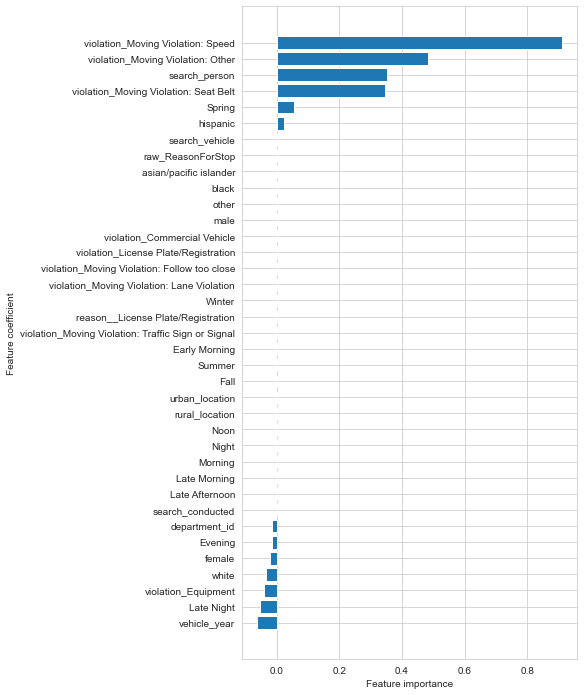

In [58]:
df, sgdc_perf, sgdc_disp = SGDC(data, 'citation_issued', 'l1')

In [59]:
df

,Features,Coefficient
4,vehicle_year,-0.062301
26,Late Night,-0.053758
13,violation_Equipment,-0.039906
10,white,-0.034770
11,female,-0.020940
23,Evening,-0.016761
3,department_id,-0.015342
0,search_conducted,0.000000
24,Late Afternoon,0.000000
25,Late Morning,0.000000


#### Findings from SGD Classifier

Like with the prior two models, the 'white' feature is more negative than the 'black' and 'hispanic' features. This also supports the findings in the original paper.

### Model Evaluation

In [60]:
performances = [logit_perf, lsvc_perf, sgdc_perf]

pd.DataFrame(performances, columns=['Model','ROC AUC Score', 'Accuracy', 'Precision', 'Recall', 'F-Score'])

,Model,ROC AUC Score,Accuracy,Precision,Recall,F-Score
0,Logistic Regression,0.610558,0.61464,0.613422,0.61464,0.612946
1,LinearSVC,0.610694,0.61480,0.613580,0.61480,0.613083
2,SGD Classifier,0.612213,0.61076,0.614048,0.61076,0.611025


In [61]:
sns.set_style('white')

Logistic Regression Model:


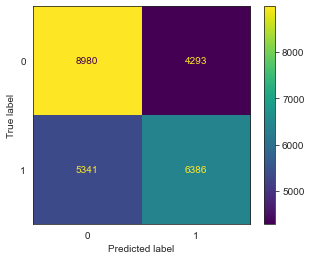

In [62]:
print('Logistic Regression Model:')
logit_disp.plot();

LinearSVC Model:


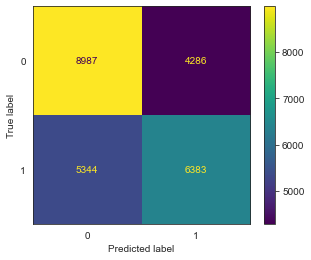

In [63]:
print('LinearSVC Model:')
lsvc_disp.plot();

SGD Classifier Model:


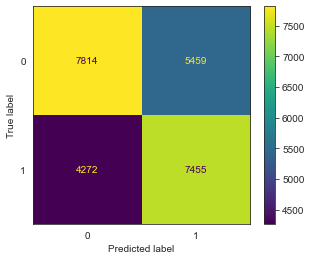

In [64]:
print('SGD Classifier Model:')
sgdc_disp.plot();

In [65]:
sns.set_style('whitegrid')

These findings suggest that the second model, the Linear SVC model, performed the best on this data. It has the highest score in all of the classification evaluation metrics selected (ROC AUC Score, Accuracy, Precision, Recall, and F-Score).

## Conclusion 2: Black and Hispanic drivers are more likely to be searched than white drivers?

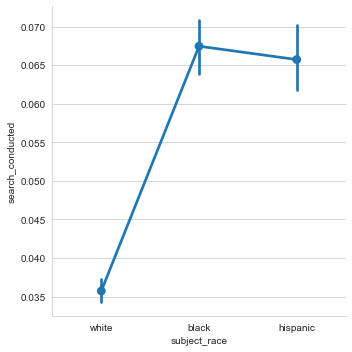

In [66]:
sns.factorplot('subject_race','search_conducted',order=['white', 'black', 'hispanic'],data=data,size=5);

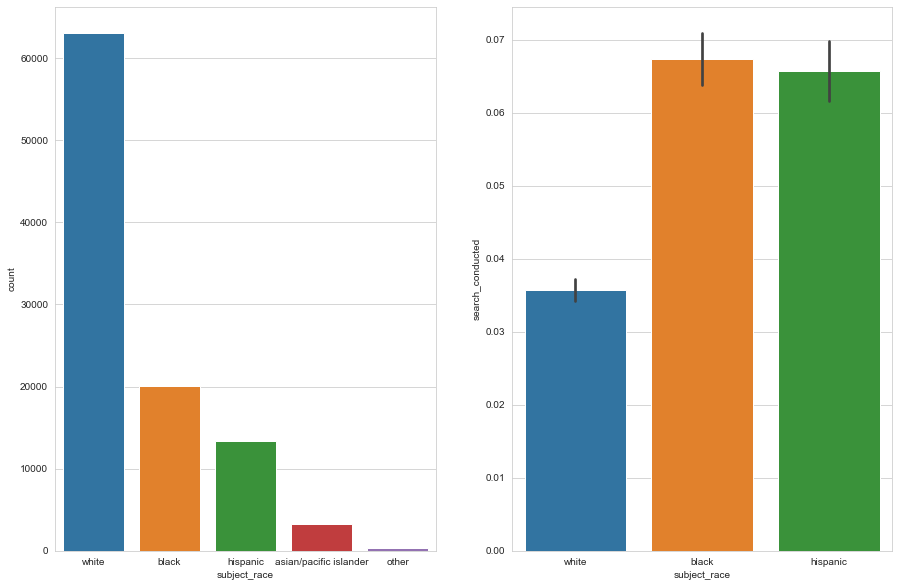

In [67]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,10))

sns.countplot(x='subject_race', data=data, ax=ax1, order=['white','black','hispanic', 'asian/pacific islander', 'other'])
race = data[["subject_race", "search_conducted"]]
sns.barplot(x='subject_race', y='search_conducted', data=race, ax=ax2, order=['white','black','hispanic']);

Uses same feature variables, but different target variable.

In [68]:
features = [
       'vehicle_year',
       'asian/pacific islander', 'black', 'hispanic',
       'other', 'white', 'female', 'male', 'violation_Equipment', 'department_id',
       'violation_Commercial Vehicle','violation_License Plate/Registration',
       'violation_Moving Violation: Follow too close',
       'violation_Moving Violation: Lane Violation',
       'violation_Moving Violation: Other',
       'violation_Moving Violation: Seat Belt',
       'violation_Moving Violation: Speed',
       'violation_Moving Violation: Traffic Sign or Signal',  'Early Morning', 'Evening',
       'Late Afternoon', 'Late Morning', 'Late Night', 'Morning', 'Night',
       'Noon', 'rural_location', 'urban_location', 'Fall', 'Spring', 'Summer',
       'Winter']

Dataset is unbalanced; far more non-search than search samples. To combat this, even out classes by selected randomly the same number of unsearched samples as there are searched samples. 

In [69]:
search = data.loc[data['search_conducted'] == 1]
no_search = data.loc[data['search_conducted'] == 0]

In [70]:
no_search_small = no_search.sample(n=len(search), random_state=42)
data_balanced = pd.concat([search, no_search_small], axis=0)

In [71]:
X = np.array(data_balanced[features]) 
y = np.array(data_balanced['search_conducted'])

In [72]:
from collections import Counter
Counter(y)

Counter({1: 4542, 0: 4542})

### Logistic Regression

In [73]:
compare_penalty_logit(X, y)

,min,max,mean_abs,n_zero,test_score
none,-0.814,0.209,0.152,0,0.658
l1,-0.332,0.168,0.107,3,0.658
l2,-0.334,0.209,0.108,0,0.658


In [74]:
compare_c_logit(X, y, p='l1', s='saga')

,c,min,max,mean_abs,n_zero,test_score
0,0.001,0.000,0.000,0.000,32,0.498
1,0.010,-0.245,0.159,0.059,12,0.653
2,0.100,-0.323,0.165,0.101,4,0.659
3,1.000,-0.332,0.168,0.107,3,0.658
4,10.000,-0.461,0.189,0.118,1,0.658
5,100.000,-0.777,0.207,0.149,0,0.658


10-fold CV F1 score: 0.667 +/- 0.019
10-fold CV ROC_AUC score: 0.717 +/- 0.017


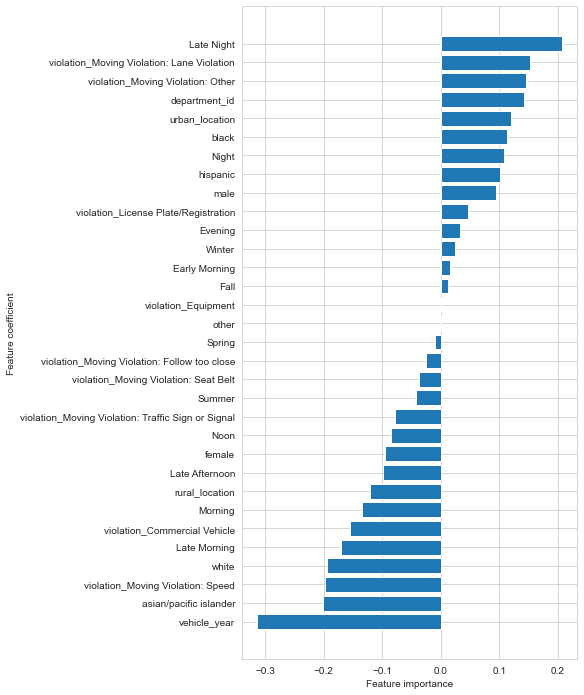

In [75]:
df, logit_perf, logit_disp = Logit(data_balanced, 'search_conducted', 'l1', .1)

In [76]:
df

,Features,Coefficient
0,vehicle_year,-0.313076
1,asian/pacific islander,-0.200854
16,violation_Moving Violation: Speed,-0.197838
5,white,-0.194700
21,Late Morning,-0.171006
10,violation_Commercial Vehicle,-0.155251
23,Morning,-0.134660
26,rural_location,-0.120900
20,Late Afternoon,-0.098100
6,female,-0.094364


### Linear SVC

In [77]:
compare_penalty_lsvc(X, y)

,min,max,mean_abs,n_zero,test_score
l1,-0.146,0.115,0.048,0,0.657
l2,-0.352,0.215,0.116,0,0.658


In [78]:
compare_c_lsvc(X, y, p='l2',s='squared_hinge', d=False)

,c,min,max,mean_abs,n_zero,test_score
0,0.001,-0.119,0.085,0.044,0,0.658
1,0.010,-0.126,0.090,0.047,0,0.656
2,0.100,-0.127,0.091,0.047,0,0.656
3,1.000,-0.127,0.091,0.047,0,0.656
4,10.000,-0.127,0.091,0.047,0,0.656
5,100.000,-0.127,0.091,0.047,0,0.656


10-fold CV F1 score: 0.667 +/- 0.020
10-fold CV ROC_AUC score: 0.718 +/- 0.018


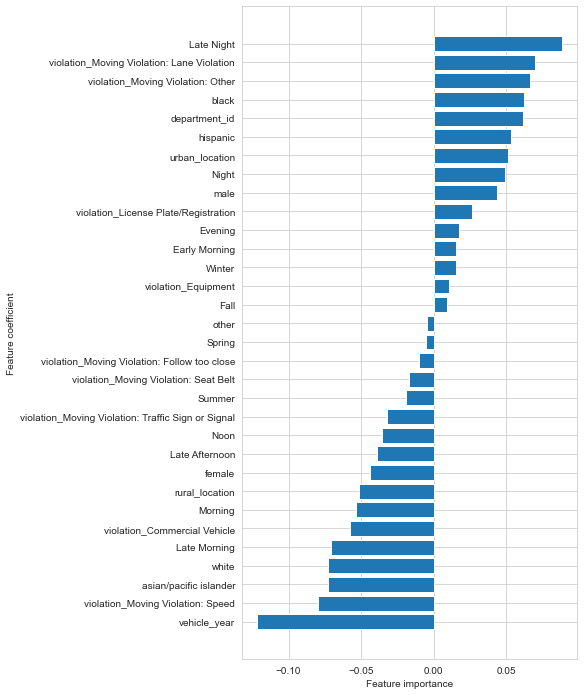

In [79]:
df, lsvc_perf, lsvc_disp = lSVC(data_balanced, 'search_conducted', p='l2', c= .001, s='squared_hinge', d=False)

In [80]:
df

,Features,Coefficient
0,vehicle_year,-0.121447
16,violation_Moving Violation: Speed,-0.079510
1,asian/pacific islander,-0.072818
5,white,-0.072647
21,Late Morning,-0.070500
10,violation_Commercial Vehicle,-0.057449
23,Morning,-0.053539
26,rural_location,-0.051287
6,female,-0.043776
20,Late Afternoon,-0.038718


### SGDClassifier

In [81]:
compare_penalty_sgdc(X, y)

,min,max,mean_abs,n_zero,test_score
l1,-0.731,0.348,0.129,15,0.641
l2,-0.504,0.356,0.142,0,0.615


10-fold CV F1 score: 0.639 +/- 0.035
10-fold CV ROC_AUC score: 0.669 +/- 0.019


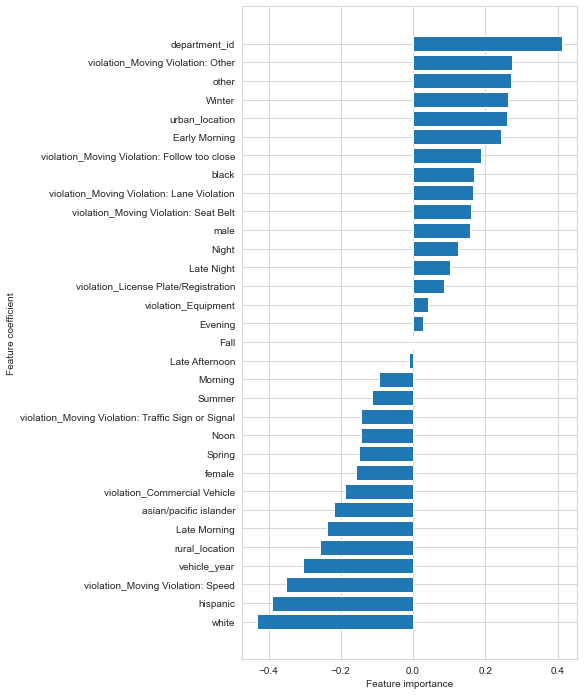

In [82]:
df, sgdc_perf, sgdc_disp = SGDC(data_balanced, 'search_conducted', 'l2')

In [83]:
df

,Features,Coefficient
5,white,-0.430852
3,hispanic,-0.390059
16,violation_Moving Violation: Speed,-0.352604
0,vehicle_year,-0.304920
26,rural_location,-0.258474
21,Late Morning,-0.237533
1,asian/pacific islander,-0.218508
10,violation_Commercial Vehicle,-0.188710
6,female,-0.157146
29,Spring,-0.149559


### Model Evaluation

In [84]:
performances = [logit_perf, lsvc_perf, sgdc_perf]

pd.DataFrame(performances, columns=['Model','ROC AUC Score', 'Accuracy', 'Precision', 'Recall', 'F-Score'])

,Model,ROC AUC Score,Accuracy,Precision,Recall,F-Score
0,Logistic Regression,0.658811,0.63868,0.936779,0.63868,0.742855
1,LinearSVC,0.661487,0.63568,0.937272,0.63568,0.740533
2,SGD Classifier,0.628867,0.61312,0.933095,0.61312,0.723358


In [85]:
sns.set_style('white')

#### <i> Note: While the classification model metrics above are tested on the full (unbalanced) dataset, the following confusion matrices display the model's performance on the training (balanced) dataset.</i>

Logistic Regression Model:


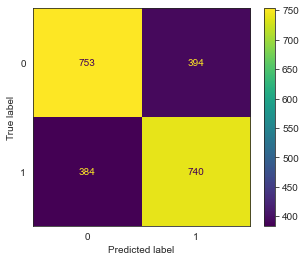

In [86]:
print('Logistic Regression Model:')
logit_disp.plot();

LinearSVC Model:


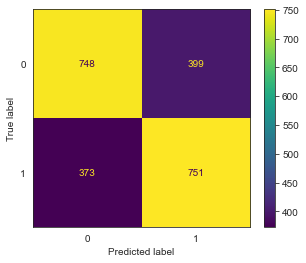

In [87]:
print('LinearSVC Model:')
lsvc_disp.plot();

SGD Classifer Model:


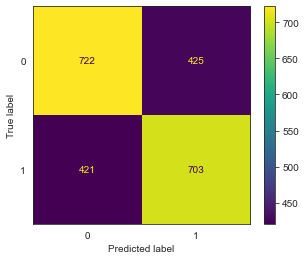

In [88]:
print('SGD Classifer Model:')
sgdc_disp.plot();

For the second hypothesis, the logistic regression model performed the best, as it has highest ROC AUC score, which is the preferred indicator for unbalanced data.

# Conclusions

1. <b>Pierson, et al.’s findings hold true in Illinois.</b>

    Black and Hispanic drivers are more likely to be both <b>ticketed and searched</b> than white drivers. 



2. <b>Further statistical hypothesis testing needed.</b>

    Classification model precision, accuracy, ROC_AUC, etc scores not very high, so further testing necessary to determine statistical significance.
